   *«Потребитель — это не просто тот, кто потребляет. Потребитель — это тот, кто осуществляется как личность только через потребление. Чем больше удаётся ему потребить, тем больше он себя чувствует личностью.»*

   --  Юлий Кагарлицкий

# Исследование прибыли для различных типов пользователей

В данной работе будут проанализированы данные о некоторых пользователях сервиса аренды самокатов GoFast из нескольких городов и проверены некоторые гипотезы, которые могут помочь бизнесу вырасти.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
from scipy.stats import binom

#### Шаг 1. Загрузка данных

Загрузим данные и посмотрим на них.

In [2]:
user = pd.read_csv('/datasets/users_go.csv')
rides = pd.read_csv('/datasets/rides_go.csv')
sub = pd.read_csv('/datasets/subscriptions_go.csv')

In [3]:
user.head(10)

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra
5,6,Регина,25,Краснодар,ultra
6,7,Игорь,23,Омск,ultra
7,8,Юрий,23,Краснодар,ultra
8,9,Ян,21,Пятигорск,ultra
9,10,Валерий,18,Екатеринбург,ultra


In [4]:
user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


In [5]:
rides.head(10)

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28
5,1,2770.890808,16.650138,2021-10-09
6,1,3039.020292,14.927879,2021-10-19
7,1,2842.118050,23.117468,2021-11-06
8,1,3412.690668,15.238072,2021-11-14
9,1,748.690645,15.041884,2021-11-22


In [6]:
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


In [7]:
sub.head(10)

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


In [8]:
sub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


Явных пропусков нет ни в одной таблице, за исключением `rides['data']` все столбцы приведены к удобному формату данных.

---

В указанных данных представленны поездки пользователя, которые должны однозначно определятся уникальным идентификатором пользователя и датой, кроме того каждый пользователь имеет имя и возраст и однозначно определяется идентификатором пользователя. Судя по данным таблицы пользователи совершают поездки на неотрицательное расстояние за понеотрицательное время, что позволяет повысить степень доверия к данным. Каждому пользователю соответсвует один из двух тарифных планов, которые отличаются стоимостью старта, стоимотью минуты поездки и обонентской платой.

#### Шаг 2. Предобработка данных

В таблице с поездками приведём столбец `date` к удобному для работы виду.

In [9]:
rides['date'] = pd.to_datetime(rides['date'], format='%Y-%m-%d')

А также создадим новый столбец с номером месяца.

In [10]:
rides['month'] = rides['date'].dt.month

Существующие данные охватывают период 2021 года.

In [11]:
print(min(rides['date']), ' - ', max(rides['date']))

2021-01-01 00:00:00  -  2021-12-30 00:00:00


Некоторые строки в `user` повторяются.

In [12]:
user.value_counts()

user_id  name       age  city            subscription_type
209      Андрей     23   Омск            ultra                2
807      Александр  28   Екатеринбург    free                 2
611      Владимир   28   Омск            ultra                2
43       Стефания   22   Омск            ultra                2
737      Мелания    27   Ростов-на-Дону  free                 2
                                                             ..
520      Анжелика   30   Екатеринбург    ultra                1
519      Даниэль    22   Ростов-на-Дону  ultra                1
518      Алиса      22   Ростов-на-Дону  ultra                1
517      Олег       25   Краснодар       ultra                1
1534     Альберт    25   Краснодар       free                 1
Length: 1534, dtype: int64

In [13]:
user.duplicated().sum()

31

Можно избавиться от повторов.

In [14]:
user = user.drop_duplicates() 

Теперь количества уникальных пользователей в таблицах `user` и `rides` совпадают.

In [15]:
len(rides['user_id'].unique())

1534

Другие таблицы не имеют дубликатов, для таблицы `rides` это можно продемонстрировать выводом ниже, для таблицы `sub` это можно заметить в явном виде, поскольку данная таблица имеет всего две строки.

In [16]:
rides.duplicated().sum()

0

In [17]:
(rides['duration'] > 5).sum() / rides['duration'].count()

0.9846136816471109

Кроме того, были обнаружены странные, выбивающиеся значения в значениях продолжительности поездки таблицы `rides`.

In [18]:
rides['duration'].value_counts().reset_index().sort_values(by='index')

,index,duration
0,0.500000,95
5956,2.035632,1
2316,2.053251,1
12510,2.180879,1
9751,2.222598,1
...,...,...
1982,38.265229,1
15085,38.352763,1
17218,39.526602,1
13406,39.873856,1


Предположим, что причиной появления таких значений является некая техническая ошибка. Поскольку строк, порождённых такой ошибкой на три порядка меньше, чем общее количество строк, мы можем их удалить из нашего анализа.

In [19]:
rides = rides[rides['duration'] != 0.5]

В данном разделе был произведён предварительный анализ данных, были удалены явные дубликаты из `user` и потенциально некорректные данные из `rides`. Кроме того, был приведён `rides[date]` к удобному для работы виду и создан столбец в котором указаны месяца поездок.

#### Шаг 3. Исследовательский анализ данных

Отобразим на графике частоту встречаемости городов. Больше всего данных из Пятигорска, в то время, как данных из Москвы наименьшее количество.

Text(0, 0.5, 'город')

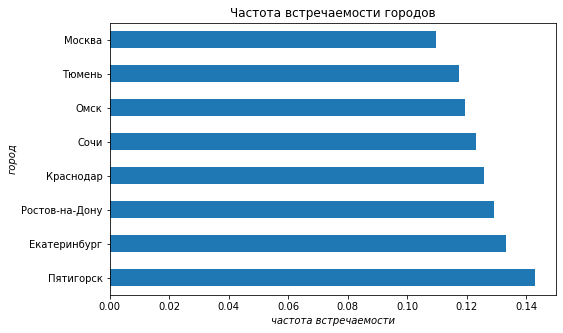

In [20]:
(
    (user['city'].value_counts() / user['city'].count())
    .plot
    .barh(figsize=(8,5))
)
plt.title('Частота встречаемости городов')
plt.xlabel('частота встречаемости', style='italic')
plt.ylabel('город', style='italic')

Большее количество людей из имеющихся данных пользуются приложением без подписки.

Text(0.5, 0, '')

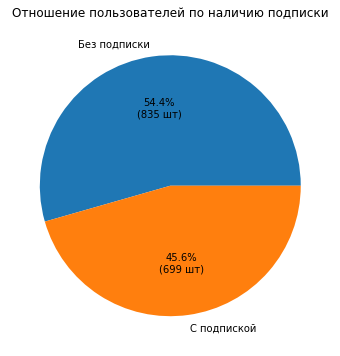

In [21]:
i = 0
def func(pct, val):
    global i
    absolute = val[i]
    i = i + 1
    return f"{pct:.1f}%\n({absolute:d} шт)"

t = (user['subscription_type'].value_counts() / user['subscription_type'].count())
t.index = ['Без подписки', 'С подпиской']
t.plot(kind='pie', figsize=(6,6), autopct=lambda pct: func(pct, user['subscription_type'].value_counts()))
plt.title('Отношение пользователей по наличию подписки')
plt.ylabel('', style='italic')
plt.xlabel('', style='italic')

Возраст пользователей из имеющихся данных распределён нормально.

Text(0.5, 0, 'возраст, год')

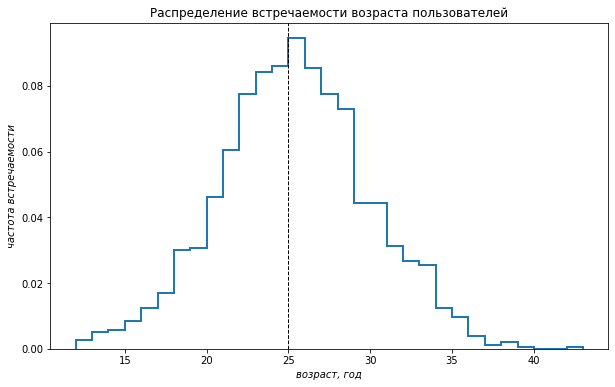

In [22]:
(
    user['age']
    .plot(kind='hist', density=True, histtype='step', bins=user['age'].value_counts().index.max() - user['age'].value_counts().index.min(), linewidth=2, figsize=(10,6))
)
plt.axvline(user['age'].median(), color='k', linestyle='dashed', linewidth=1)
plt.title('Распределение встречаемости возраста пользователей')
plt.ylabel('частота встречаемости', style='italic')
plt.xlabel('возраст, год', style='italic')

Распределение расстояний, которое проезжают пользователи за одну поездку имеет два ярковыраженных пика, меньший из которых соответсвует меньшему расстоянию и несколько неярковыраженных, которые начинаются от 4000 м.

In [23]:
user['age'].describe()

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

Text(0.5, 0, 'расстояние, м')

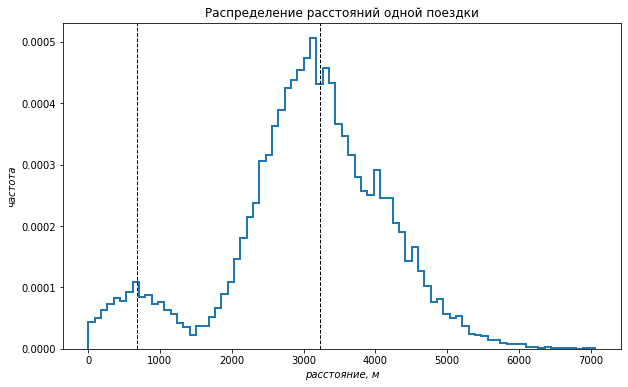

In [24]:
(
    rides['distance']
    .plot(kind='hist', density=True, histtype='step', bins=80, linewidth=2, figsize=(10,6))
)
plt.axvline(rides.loc[rides['distance'] < 1500, 'distance'].median(), color='k', linestyle='dashed', linewidth=1)
plt.axvline(rides.loc[rides['distance'] >= 1500, 'distance'].median(), color='k', linestyle='dashed', linewidth=1)
plt.title('Распределение расстояний одной поездки')
plt.ylabel('частота', style='italic')
plt.xlabel('расстояние, м', style='italic')

Продолжительность поездок пользователей распределена нормально.

Text(0.5, 0, 'время, мин')

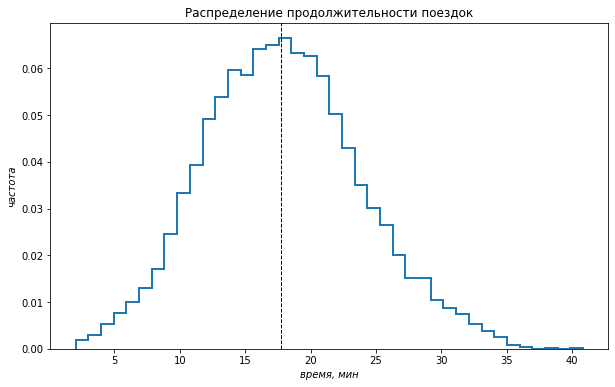

In [25]:
(
    rides['duration']
    .plot(kind='hist', density=True, histtype='step', bins=40, linewidth=2, figsize=(10,6))
)
plt.axvline(rides['duration'].median(), color='k', linestyle='dashed', linewidth=1)
plt.title('Распределение продолжительности поездок')
plt.ylabel('частота', style='italic')
plt.xlabel('время, мин', style='italic')

#### Шаг 4. Объединение данных

Объеденим данные о пользователях, поездках и подписках в один датафрейм.

In [26]:
data = user.merge(rides, how='inner', on='user_id')
data = data.merge(sub, how='inner', on='subscription_type')

In [27]:
rides.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17973 entries, 0 to 18067
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   17973 non-null  int64         
 1   distance  17973 non-null  float64       
 2   duration  17973 non-null  float64       
 3   date      17973 non-null  datetime64[ns]
 4   month     17973 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(2)
memory usage: 842.5 KB


In [28]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17973 entries, 0 to 17972
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            17973 non-null  int64         
 1   name               17973 non-null  object        
 2   age                17973 non-null  int64         
 3   city               17973 non-null  object        
 4   subscription_type  17973 non-null  object        
 5   distance           17973 non-null  float64       
 6   duration           17973 non-null  float64       
 7   date               17973 non-null  datetime64[ns]
 8   month              17973 non-null  int64         
 9   minute_price       17973 non-null  int64         
 10  start_ride_price   17973 non-null  int64         
 11  subscription_fee   17973 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(3)
memory usage: 1.8+ MB


Создадим два отдельных датафрейма с данными о пользователях с подпиской и без неё.

In [29]:
data_free = data[data['subscription_type'] == 'free'].drop(columns=['subscription_type']).reset_index(drop=True)
data_ultra = data[data['subscription_type'] == 'ultra'].drop(columns=['subscription_type']).reset_index(drop=True)

При этом распределение расстояний, проезжаемых пользователями с разными типами поездок, будет различным. Пользователи без подписки демонстрируют более 'расплывающуюся' картину распределения, мода их центрального пика в два раза меньше моды аналогичного пика для пользователей с подпиской `ultra`, и дисперсия этого пика больше. Другой ярковыраженный пик более ярковыраженн у пользователей без подписки: у него больше мода и больше расстояние до медианы большего пика, однако у пользователей с подпиской `ultra` этот пик также обладает меньшей дисперсией.

Text(0.5, 0, 'расстояние, м')

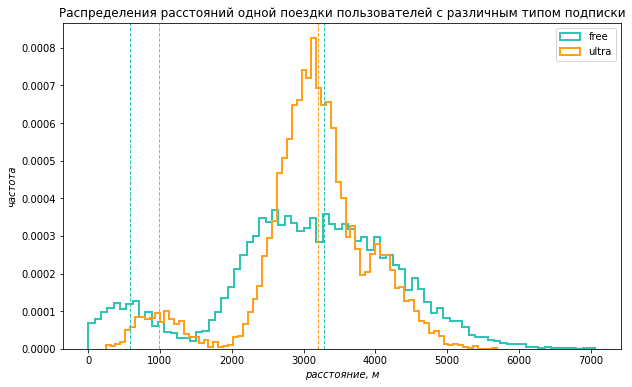

In [30]:
(
    data_free['distance']
    .plot(kind='hist', density=True, histtype='step', color='#2EC4B6', bins=80, linewidth=2, figsize=(10,6))
)
(
    data_ultra['distance']
    .plot(kind='hist', density=True, histtype='step', color='#FF9F1C', bins=80, linewidth=2, figsize=(10,6))
)
plt.legend(['free', 'ultra'])
plt.title('Распределения расстояний одной поездки пользователей с различным типом подписки')
plt.axvline(data_free.loc[data_free['distance'] < 1500, 'distance'].median(), color='#2EC4B6', linestyle='dashed', linewidth=1)
plt.axvline(data_free.loc[data_free['distance'] >= 1500, 'distance'].median(), color='#2EC4B6', linestyle='dashed', linewidth=1)
plt.axvline(data_ultra.loc[data_ultra['distance'] < 1900, 'distance'].median(), color='#FF9F1C', linestyle='dashed', linewidth=1)
plt.axvline(data_ultra.loc[data_ultra['distance'] >= 1900, 'distance'].median(), color='#FF9F1C', linestyle='dashed', linewidth=1)
plt.ylabel('частота', style='italic')
plt.xlabel('расстояние, м', style='italic')

Распределение продолжительности поездок у пользоваелей имеют сходие медианы, но мода для распределения пользователей с подпиской `ultra` выше, чем для распределения пользователей без подписки.

Text(0.5, 0, 'время, мин')

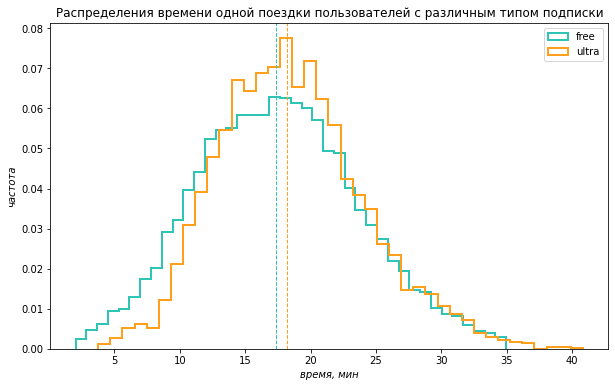

In [31]:
(
    data_free['duration']
    .plot(kind='hist', density=True, histtype='step', color='#2EC4B6', bins=40, linewidth=2, figsize=(10,6))
)
(
    data_ultra['duration']
    .plot(kind='hist', density=True, histtype='step', color='#FF9F1C', bins=40, linewidth=2, figsize=(10,6))
)
plt.legend(['free', 'ultra'])
plt.title('Распределения времени одной поездки пользователей с различным типом подписки')
plt.axvline(data_free['duration'].median(), color='#2EC4B6', linestyle='dashed', linewidth=1)
plt.axvline(data_ultra['duration'].median(), color='#FF9F1C', linestyle='dashed', linewidth=1)
plt.ylabel('частота', style='italic')
plt.xlabel('время, мин', style='italic')

#### Шаг 5. Подсчёт выручки

Подсчитаем помесячную выручку для каждого пользователя и сохраним информацию о ней в новую таблицу.

In [34]:
d_cash = pd.pivot_table(data, index=['month', 'user_id'], values=['distance', 'duration'], aggfunc=np.sum)
d_cash['count'] = pd.pivot_table(data, index=['month', 'user_id'], values='distance', aggfunc='count')

data['cash_time'] = np.ceil(data['duration']) * data['minute_price']
t = pd.pivot_table(data, index=['month', 'user_id'], values=['cash_time', 'start_ride_price'], aggfunc=np.sum)
t['subscription_fee'] = pd.pivot_table(data, index=['month', 'user_id'], values=['subscription_fee'], aggfunc='first')
data.drop(columns='cash_time')

d_cash['cash'] = t['start_ride_price'] + t['subscription_fee'] + t['cash_time']
del t
d_cash['subscription_type'] = pd.pivot_table(data, index=['month', 'user_id'], values=['subscription_type'], aggfunc='first')
d_cash

distance   duration  count   cash subscription_type
month user_id                                                        
1     1        7027.511294  41.416640      2  451.0             ultra
      3        3061.777147  12.654443      1  277.0             ultra
      5        3914.646990  12.395153      1  277.0             ultra
      7        6478.080979  27.653450      2  367.0             ultra
      12       3577.151148  32.462907      1  397.0             ultra
...                    ...        ...    ...    ...               ...
12    1525     4597.854350  33.220866      1  322.0              free
      1526     3644.121544  22.665456      1  234.0              free
      1528     3998.569324  10.272902      1  138.0              free
      1532     6111.889853  40.128222      2  436.0              free
      1534     2371.711192  15.893917      1  178.0              free

[11300 rows x 5 columns]

#### Шаг 6. Проверка гипотез

Сравним средние времена поездок пользователей с подпиской `ultra` и без неё. В качестве погрешности будем использовать одно стандартное отклонение, примерно оценённое поправкой Бесселя.

In [35]:
s = 0
for i in data_ultra['duration']:
    s = s + (i - data_ultra['duration'].mean()) ** 2
print(data_ultra['duration'].mean(), s / (len(data_ultra['duration']) - 1))

18.54198516280583 31.04772258362432


In [36]:
s = 0
for i in data_free['duration']:
    s = s + (i - data_free['duration'].mean()) ** 2
print(data_free['duration'].mean(), s / (len(data_free['duration']) - 1))

17.530771268800226 37.97774631872502


Средние времена поездок различаются не сильно. Проверим также тратят ли пользователи с подпиской больше времени на поездки, поскольку такие пользователи могут принести большую прибыль компании.
Нулевая гипотеза такой проверки будет заключаться в том что среднее время поездки пользователей с подпиской `ultra` будет равно среднму времени поездки пользователей без подписки. Альтернативная гипотеза будет заключаться в том, что среднее время поездки пользователей с подпиской `ultra` будет больше среднего времени поездки пользователей без подписки.

In [37]:
alpha = 0.05 

results = st.ttest_ind(data_ultra['duration'], data_free['duration'], equal_var=False, alternative='greater')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('В среднем пользователи с подпиской `ultra` тратят больше времени на поездки, чем пользователи без подписки.')
else:
    print('В среднем пользователи с подпиской `ultra` тратят НЕ больше времени на поездки, чем пользователи без подписки.') 

p-значение: 1.6162210195311063e-29
В среднем пользователи с подпиской `ultra` тратят больше времени на поездки, чем пользователи без подписки.


Кроме того найдём среднюю по пользоватетелям и среднюю по поездкам разницу во времени поездок между людьми с подпиской `ultra` и без неё.

Text(0.5, 0, 'месяц')

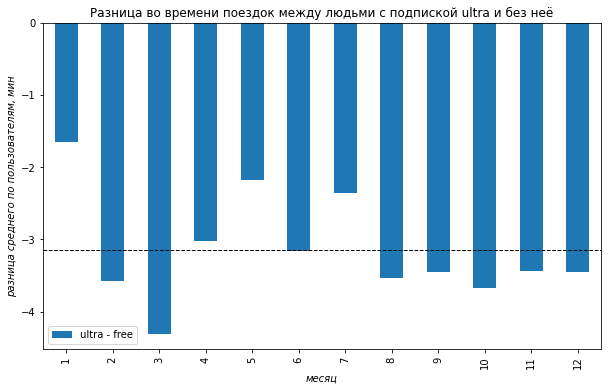

In [38]:
(
    (pd.pivot_table(d_cash[d_cash['subscription_type'] == 'ultra'], index=['month'], values='duration', aggfunc='mean') - pd.pivot_table(d_cash[d_cash['subscription_type'] == 'free'], index=['month'], values='duration', aggfunc='mean'))
    .plot(kind='bar', figsize=(10,6), align='center')
)
plt.legend(['ultra - free'])
plt.title('Разница во времени поездок между людьми с подпиской ultra и без неё')
plt.axhline((pd.pivot_table(d_cash[d_cash['subscription_type'] == 'ultra'], index=['month'], values='duration', aggfunc='mean') - pd.pivot_table(d_cash[d_cash['subscription_type'] == 'free'], index=['month'], values='duration', aggfunc='mean')).mean()['duration'], color='k', linestyle='dashed', linewidth=1)
plt.ylabel('разница среднего по пользователям, мин', style='italic')
plt.xlabel('месяц', style='italic')

В среднем пользователи без подписки проводят больше времени в поездке, чем пользователи без неё. Это справедливо для каждого из представленных месяцев.

Text(0.5, 0, 'месяц')

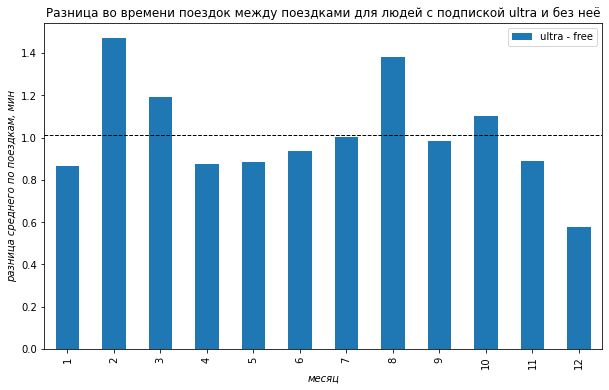

In [39]:
(
    (pd.pivot_table(d_cash[d_cash['subscription_type'] == 'ultra'], index=['month'], values='duration', aggfunc='sum')['duration'] / pd.pivot_table(d_cash[d_cash['subscription_type'] == 'ultra'], index=['month'], values='count', aggfunc='sum')['count'] - pd.pivot_table(d_cash[d_cash['subscription_type'] == 'free'], index=['month'], values='duration', aggfunc='sum')['duration'] / pd.pivot_table(d_cash[d_cash['subscription_type'] == 'free'], index=['month'], values='count', aggfunc='sum')['count'])
    .plot(kind='bar', figsize=(10,6), align='center')
)
plt.legend(['ultra - free'])
plt.title('Разница во времени поездок между поездками для людей с подпиской ultra и без неё')
plt.axhline((pd.pivot_table(d_cash[d_cash['subscription_type'] == 'ultra'], index=['month'], values='duration', aggfunc='sum')['duration'] / pd.pivot_table(d_cash[d_cash['subscription_type'] == 'ultra'], index=['month'], values='count', aggfunc='sum')['count'] - pd.pivot_table(d_cash[d_cash['subscription_type'] == 'free'], index=['month'], values='duration', aggfunc='sum')['duration'] / pd.pivot_table(d_cash[d_cash['subscription_type'] == 'free'], index=['month'], values='count', aggfunc='sum')['count']).mean(), color='k', linestyle='dashed', linewidth=1)
plt.ylabel('разница среднего по поездкам, мин', style='italic')
plt.xlabel('месяц', style='italic')

Хоть пользователи без подписки и проводят больше времени в поездках, чем пользователи с подпиской, но сами их поездки в среднем короче по времени, чем поездки пользователей с подпиской. Это справедливо для каждого из месяцев.

---

Для каждого месяца проверим, приносят ли пользователи с подпиской больше прибыли, чем пользователи без неё. Нулевая гипотеза такой проверки будет заключаться в том что для каждого месяца средняя прибыль пользователей с подпиской `ultra` будет равна средней прибыли пользователей без подписки. Альтернативная гипотеза будет заключаться в том, что для каждого месяца средняя время прибыль пользователей с подпиской `ultra` будет больше средней прибыли пользователей без подписки.

In [40]:
alpha = 0.05

results = st.ttest_ind(d_cash.reset_index().loc[(d_cash.reset_index()['subscription_type'] == 'ultra'), 'cash'], d_cash.reset_index().loc[(d_cash.reset_index()['subscription_type'] == 'free'), 'cash'], equal_var=False, alternative='greater')
    
print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('В среднем пользователи с подпиской `ultra` приносят больше прибыли, чем пользователи без подписки.')
else:
    print('В среднем пользователи с подпиской `ultra` приносят НЕ больше прибыли, чем пользователи без подписки.') 

p-значение: 2.4970242872858465e-38
В среднем пользователи с подпиской `ultra` приносят больше прибыли, чем пользователи без подписки.


In [41]:
alpha = 0.05 

for i in range(1,13):
    results = st.ttest_ind(d_cash.reset_index().loc[(d_cash.reset_index()['month'] == i) & (d_cash.reset_index()['subscription_type'] == 'ultra'), 'cash'], d_cash.reset_index().loc[(d_cash.reset_index()['month'] == i) & (d_cash.reset_index()['subscription_type'] == 'free'), 'cash'], equal_var=False, alternative='greater')
    
    print('в', i, 'месяце p-значение:', results.pvalue)

    if results.pvalue < alpha:
        print('Для', i, 'месяца в среднем пользователи с подпиской `ultra` приносят больше прибыли, чем пользователи без подписки.')
    else:
        print('Для', i, 'месяца в среднем пользователи с подпиской `ultra` приносят НЕ больше прибыли, чем пользователи без подписки.') 

в 1 месяце p-значение: 2.197135572336625e-07
Для 1 месяца в среднем пользователи с подпиской `ultra` приносят больше прибыли, чем пользователи без подписки.
в 2 месяце p-значение: 3.071554863065948e-05
Для 2 месяца в среднем пользователи с подпиской `ultra` приносят больше прибыли, чем пользователи без подписки.
в 3 месяце p-значение: 0.009707921212132712
Для 3 месяца в среднем пользователи с подпиской `ultra` приносят больше прибыли, чем пользователи без подписки.
в 4 месяце p-значение: 0.00025364856368637317
Для 4 месяца в среднем пользователи с подпиской `ultra` приносят больше прибыли, чем пользователи без подписки.
в 5 месяце p-значение: 4.949306507837134e-06
Для 5 месяца в среднем пользователи с подпиской `ultra` приносят больше прибыли, чем пользователи без подписки.
в 6 месяце p-значение: 3.514168315971436e-05
Для 6 месяца в среднем пользователи с подпиской `ultra` приносят больше прибыли, чем пользователи без подписки.
в 7 месяце p-значение: 1.2287779732537339e-05
Для 7 месяца

Кроме того найдём среднюю по пользоватетелям и среднюю по поездкам разницу в принесённой прибыли между людьми с подпиской `ultra` и без неё.

Text(0.5, 0, 'месяц')

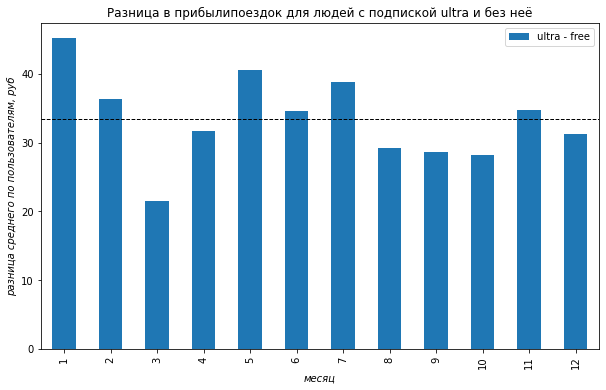

In [42]:
(
    (pd.pivot_table(d_cash[d_cash['subscription_type'] == 'ultra'], index=['month'], values='cash', aggfunc='mean') - pd.pivot_table(d_cash[d_cash['subscription_type'] == 'free'], index=['month'], values='cash', aggfunc='mean'))
    .plot(kind='bar', figsize=(10,6), align='center')
)
plt.legend(['ultra - free'])
plt.title('Разница в прибылипоездок для людей с подпиской ultra и без неё')
plt.axhline((pd.pivot_table(d_cash[d_cash['subscription_type'] == 'ultra'], index=['month'], values='cash', aggfunc='mean') - pd.pivot_table(d_cash[d_cash['subscription_type'] == 'free'], index=['month'], values='cash', aggfunc='mean')).mean()['cash'], color='k', linestyle='dashed', linewidth=1)
plt.ylabel('разница среднего по пользователям, руб', style='italic')
plt.xlabel('месяц', style='italic')

В среднем пользователи с подпиской приносят больше прибыли, чем пользователи без подписки. Это справедливо для каждого месяца, в особенности для Января.

Text(0.5, 0, 'месяц')

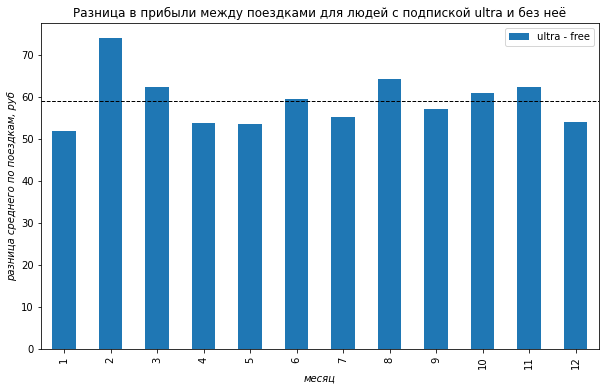

In [43]:
(
    (pd.pivot_table(d_cash[d_cash['subscription_type'] == 'ultra'], index=['month'], values='cash', aggfunc='sum')['cash'] / pd.pivot_table(d_cash[d_cash['subscription_type'] == 'ultra'], index=['month'], values='count', aggfunc='sum')['count'] - pd.pivot_table(d_cash[d_cash['subscription_type'] == 'free'], index=['month'], values='cash', aggfunc='sum')['cash'] / pd.pivot_table(d_cash[d_cash['subscription_type'] == 'free'], index=['month'], values='count', aggfunc='sum')['count'])
    .plot(kind='bar', figsize=(10,6), align='center')
)
plt.legend(['ultra - free'])
plt.title('Разница в прибыли между поездками для людей с подпиской ultra и без неё')
plt.axhline((pd.pivot_table(d_cash[d_cash['subscription_type'] == 'ultra'], index=['month'], values='cash', aggfunc='sum')['cash'] / pd.pivot_table(d_cash[d_cash['subscription_type'] == 'ultra'], index=['month'], values='count', aggfunc='sum')['count'] - pd.pivot_table(d_cash[d_cash['subscription_type'] == 'free'], index=['month'], values='cash', aggfunc='sum')['cash'] / pd.pivot_table(d_cash[d_cash['subscription_type'] == 'free'], index=['month'], values='count', aggfunc='sum')['count']).mean(), color='k', linestyle='dashed', linewidth=1)
plt.ylabel('разница среднего по поездкам, руб', style='italic')
plt.xlabel('месяц', style='italic')

В среднем пользователи с подпиской совершают поездки, приносящие большую прибыль, чем пользователи без подписки.

---

Расстояние одной поездки в 3130 метров является оптимальным с точки зрения износа самоката. Проверим, превышают ли пользователи с подпиской это расстояние за одну поездку. Нулевая гипотеза такой проверки будет заключаться в том что среднее расстояние, которое проезжают пользователей с подпиской `ultra` за одну поездку будет равно 3130 метрам. Альтернативная гипотеза будет заключаться в том, что среднее расстояние, которое проезжают пользователей с подпиской `ultra` за одну поездку будет больше 3130 метров.

In [44]:
alpha = 0.05

results = st.ttest_1samp(data_ultra.loc[data_ultra['distance'] >= 1900, 'distance'], 3130, alternative = 'greater')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('В среднем пользователи с подпиской `ultra` проезжают расстояние большее 3130 метров')
else:
    print('В среднем пользователи с подпиской `ultra` проезжают расстояние НЕ большее 3130 метров')

p-значение: 1.061917530430858e-99
В среднем пользователи с подпиской `ultra` проезжают расстояние большее 3130 метров


In [45]:
alpha = 0.05

results = st.ttest_1samp(data_ultra['distance'], 3130, alternative = 'greater')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('В среднем пользователи с подпиской `ultra` проезжают расстояние большее 3130 метров')
else:
    print('В среднем пользователи с подпиской `ultra` проезжают расстояние НЕ большее 3130 метров')

p-значение: 0.9195368847849785
В среднем пользователи с подпиской `ultra` проезжают расстояние НЕ большее 3130 метров


Кроме того можено отметить на графике средние величины расстояний, которые проезжают пользователи, превышающие оптимальное значение расстояния с точки зрения износа самоката.

Text(0.5, 0, 'расстояние, м')

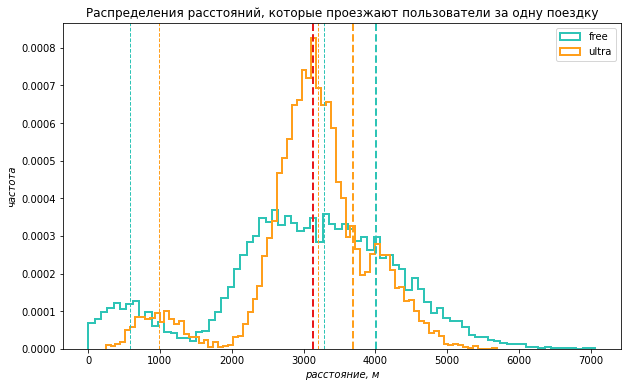

In [46]:
(
    data_free['distance']
    .plot(kind='hist', density=True, histtype='step', color='#2EC4B6', bins=80, linewidth=2, figsize=(10,6))
)
(
    data_ultra['distance']
    .plot(kind='hist', density=True, histtype='step', color='#FF9F1C', bins=80, linewidth=2, figsize=(10,6))
)
plt.legend(['free', 'ultra'])
plt.title('Распределения расстояний, которые проезжают пользователи за одну поездку')
plt.axvline(data_free.loc[data_free['distance'] < 1500, 'distance'].median(), color='#2EC4B6', linestyle='dashed', linewidth=1)
plt.axvline(data_free.loc[data_free['distance'] >= 1500, 'distance'].median(), color='#2EC4B6', linestyle='dashed', linewidth=1)
plt.axvline(data_ultra.loc[data_ultra['distance'] < 1900, 'distance'].median(), color='#FF9F1C', linestyle='dashed', linewidth=1)
plt.axvline(data_ultra.loc[data_ultra['distance'] >= 1900, 'distance'].median(), color='#FF9F1C', linestyle='dashed', linewidth=1)
plt.axvline(3130, color='#E81A1A', linestyle='dashed', linewidth=2)
plt.axvline(data_free[data_free['distance'] > 3130].groupby('user_id')['distance'].mean().mean(), color='#2EC4B6', linestyle='dashed', linewidth=2)
plt.axvline(data_ultra[data_ultra['distance'] > 3130].groupby('user_id')['distance'].mean().mean(), color='#FF9F1C', linestyle='dashed', linewidth=2)
plt.ylabel('частота', style='italic')
plt.xlabel('расстояние, м', style='italic')

---

Техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него.

Для проверки гипотезы об улучшении работы серверов приложения и последующего уменьшения количества обращений в техподдержку необходимо проверить гипотезу о равенстве средних для зависимых выборок данных о количстве обращений до обновления работы серверов и после этого обновлени. Чтобы это сделать можно воспользоваться функцией `st.ttest_rel()`.

#### Шаг 7. Распределения

Отделу маркетинга GoFast поставили задачу: нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 100 существующих клиентов должны продлить эту подписку. То есть по завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соответствующий платёж. 
Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают 10 % пользователей. Выясним, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5 %.

Для того, чтобы вероятность невыполнения плана в 100 подписок была менее 5% необходимо разослать 1169 промокодов


Text(0.5, 0, 'промокоды, шт.')

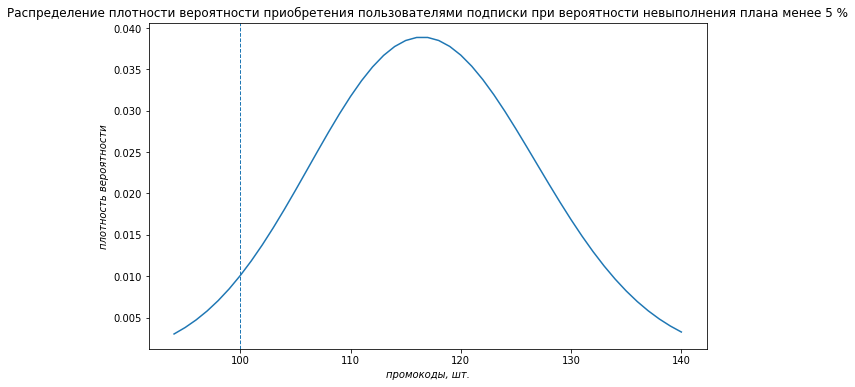

In [57]:
p = 0.1

for n in range(200,1800):
    mu = n * p
    sigma = np.sqrt(n * p * (1 - p))

    x = st.norm(mu, sigma) 
    if (1 - x.cdf(100)) >= 0.95:
        print('Для того, чтобы вероятность невыполнения плана в 100 подписок была менее 5% необходимо разослать', n, 'промокодов')
        break

fig, ax = plt.subplots(figsize=(10,6))
x = np.arange(binom.ppf(0.01, n, p), binom.ppf(0.99, n, p))
plt.plot(x, binom.pmf(x, n, p))
plt.title('Распределение плотности вероятности приобретения пользователями подписки при вероятности невыполнения плана менее 5 %')
plt.axvline(100, linestyle='dashed', linewidth=1)
plt.ylabel('плотность вероятности', style='italic')
plt.xlabel('промокоды, шт.', style='italic')

Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать. Известно, что уведомления открывают около 40 % получивших клиентов. Отдел планирует разослать 1 млн уведомлений. С помощью аппроксимации построим график распределения и оценем вероятность того, что уведомление откроют не более 399,5 тыс. пользователей.

Вероятность того, что уведомление откроет не более 399.5 пользователей равна: 0.48712642829977193


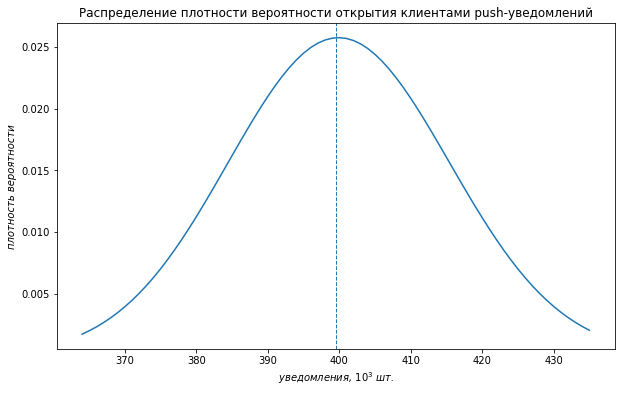

In [48]:
n = 1000
p = 0.4

x = np.arange(binom.ppf(0.01, n, p), binom.ppf(0.99, n, p))
fig, ax = plt.subplots(figsize=(10,6))
plt.plot(x, binom.pmf(x, n, p))
plt.title('Распределение плотности вероятности открытия клиентами push-уведомлений')
plt.axvline(399.5, linestyle='dashed', linewidth=1)
plt.ylabel('плотность вероятности', style='italic')
plt.xlabel('уведомления, $10^3$ шт.', style='italic')

mu = n * p
sigma = np.sqrt(n * p * (1 - p))

x = st.norm(mu, sigma) 

print('Вероятность того, что уведомление откроет не более 399.5 пользователей равна:', x.cdf(399.5))

# Вывод

В данной работе были исследованы распределения расстояний, времён и прибыли для пользователей с подпиской `ultra` и без неё.

Пользователи с подпиской `ultra` тратят больше денег, но не тратят больше времени на поездки, чем пользователи без такой подписки. Это справедливо для каждого месяца 2021 года. В среднем пользователи с подпиской проезжают расстояние не критичное для износа самоката.

Тезисно можно сделать следующие выводы, которые можно сделать после анализа:
- В среднем пользователи с подпиской `ultra` тратят больше времени на поездки, чем пользователи без подписки.
- Хоть пользователи без подписки и проводят больше времени в поездках, чем пользователи с подпиской, но сами их поездки в среднем короче по времени, чем поездки пользователей с подпиской.
- В среднем пользователи с подпиской `ultra` приносят больше прибыли, чем пользователи без подписки.
- В среднем пользователи с подпиской совершают поездки, приносящие большую прибыль, чем пользователи без подписки.
- В среднем пользователи с подпиской `ultra` проезжают расстояние НЕ большее 3130 метров